In [23]:
import seaborn as sns
import pandas as pd
import numpy as np

import os

import numpy as np
import pandas as pd
import seaborn as sns

from app import app
from app.Investigation.DataInteractor.data_fetcher import DataFetcher

from heatmap import corrplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import matplotlib.pyplot as plt

from scipy import integrate, stats
from app import app

# Regression models
import statsmodels.api as sm
from statsmodels.formula.api import ols
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# Save model
import pickle

import os

from app.Investigation.Route_segmentation.segmentation import gen_traces

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
print(os.environ["PATH"])

import app.Investigation.OpenStreetMaps.associate_edges_to_operation as associate
# The OSM Graph


C:\Users\Santiago\.conda\envs\ox;C:\Users\Santiago\.conda\envs\ox\Library\mingw-w64\bin;C:\Users\Santiago\.conda\envs\ox\Library\usr\bin;C:\Users\Santiago\.conda\envs\ox\Library\bin;C:\Users\Santiago\.conda\envs\ox\Scripts;C:\Users\Santiago\.conda\envs\ox\bin;C:\ProgramData\Anaconda3\condabin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\libnvvp;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Windows\System32\OpenSSH;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\Program Files\Git\cmd;C:\Program Files\PuTTY;C:\Program Files\OpenVPN\bin;C:\Program Files (x86)\Eclipse\Sumo\bin;C:\Program Files (x86)\Eclipse\Sumo\tools;C:\Program Files\NVIDIA Corporation\Nsight Compute 2020.3.0;C:\Program Files\nodejs;C:\Program Files\Amazon\AWSCLIV2;C:\Program Files\Docker\Docker\resources\bin;C:\ProgramData\DockerDeskt

# Read operation data

In [92]:
name = "renault"  # input()
data_path = os.path.join(app.root_path) + "/DataBackup/" + name

try:
    loaded_data = pd.read_hdf(
        data_path + "_data.h5", key=name + "_updated_df_operation"
    )
    features = pd.read_hdf(data_path + "_data.h5", key=name + "_segments")
    features = segments[segments["mean_speed"] > 0]
    features = segments[segments["consumption_per_km"] < 10]
    features = segments[segments["consumption_per_km"] > -10]

except FileNotFoundError:
    print("Enter query")
    query = input() or "SELECT * from operation limit 10"
    print(query)
    data_fetcher = DataFetcher()
    data_fetcher.upload_data_to_h5(name, query)
    loaded_data = pd.read_hdf(
        data_path + "_data.h5", key=name + "_updated_df_operation"
    )
    features = pd.read_hdf(data_path + "_data.h5", key=name + "_segments")

loaded_data.vehicle_id.unique()

array(['FSV110', 'GHW284', 'BOTE01', 'FRV020', 'BOTE02', 'FVQ731',
       'bote_proyecto_integrado2021', 'GVQ446', 'BICI01', 'EGZ112'],
      dtype=object)

# Validation of run metric

In [93]:

print(loaded_data['run'][loaded_data['vehicle_id']=='FSV110'].sum()/1000)
print(loaded_data['run'][loaded_data['vehicle_id']=='GHW284'].sum()/1000)
print(loaded_data['run'][loaded_data['vehicle_id']=='EGZ112'].sum()/1000, "\n")


print(loaded_data['odometer'][loaded_data['vehicle_id']=='FSV110'].iloc[-1] - loaded_data['odometer'][loaded_data['vehicle_id']=='FSV110'].iloc[0])
print(loaded_data['odometer'][loaded_data['vehicle_id']=='GHW284'].iloc[-1] - loaded_data['odometer'][loaded_data['vehicle_id']=='GHW284'].iloc[0])


448.7245327608838
10186.896434852826
77436.56509865921 

443.0
7024.76


In [94]:
loaded_data = loaded_data[loaded_data.power_kw != 0]

#### Corrigiendo usuarios

In [95]:

loaded_data.user_name[(loaded_data.user_name == '1er_alquiler') &
                        (loaded_data.vehicle_id =='FSV110')] = 'Santiago_Echavarria_FSV110'

loaded_data.user_name[(loaded_data.user_name == '1er_alquiler') &
                        (loaded_data.vehicle_id =='GHW284')] = 'Juan_David_Mira_Alq2'

loaded_data.user_name[(loaded_data.user_name == 'Juan_David_Mira') &
                        (loaded_data.timestamp2 > 1.608e9)] = 'Juan_David_Mira_03'

loaded_data.user_name[(loaded_data.user_name == 'Juan_David_Mira')] = 'Juan_David_Mira_01'

loaded_data.user_name[(loaded_data.user_name == 'Juan_Mira')] = 'Juan_David_Mira_02'

loaded_data.user_name.unique()

<ipython-input-95-f303179e4a02>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loaded_data.user_name[(loaded_data.user_name == '1er_alquiler') &
<ipython-input-95-f303179e4a02>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loaded_data.user_name[(loaded_data.user_name == 'Juan_David_Mira') &
<ipython-input-95-f303179e4a02>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loaded_data.user_name[(loaded_data.user_name == 'Juan_David_

array(['Santiago_Echavarria_FSV110', 'Juan_David_Mira_Alq2',
       'Ricardo_Mejia', 'Santiago_Echavarria_01', 'Santiago_Echavarria',
       'Jose_Alejandro_Montoya', 'Juan_Gregorio_Arrieta',
       'Juan_David_Mira_01', 'Mauricio_Fernandez', 'Sergio',
       'Jesus_Villa', 'Juan_David_Mira_02', 'Juan_David_Ochoa',
       'David_Rios', 'Ana_Cristina_G', 'Juan_David_Mira_03',
       'Esterban_Betancur', 'None', 'sechava4', 'Erick_Gomez', 'esgomezo',
       'usuarios_eafit_vehiculo_2'], dtype=object)

#### Corrigiendo los pesos
https://verne.elpais.com/verne/2016/04/19/articulo/1461079768_768006.html 61kg para mujeres y 67kg para hombres

In [96]:
# Para el ZOE y LEAF respectivamente 
loaded_data.mass[loaded_data.mass == 170] = 1502
loaded_data.mass[loaded_data.mass == 1528] = 1562
loaded_data.mass[loaded_data.mass == 1584] = 1564

# Con acompañante mujer
loaded_data['mass'] = np.where((
    (loaded_data['user_name'] == 'Juan_David_Ochoa') |
    (loaded_data['user_name'] == 'Ricardo_Mejia') |
    (loaded_data['user_name'] == 'Jose_Alejandro_Montoya') |
    (loaded_data['user_name'] == 'Ana_Cristina_G') | 
    (loaded_data['user_name'] == 'Esterban_Betancur') | 
    (loaded_data['user_name'] == 'Juan_Gregorio_Arrieta') |
    (loaded_data['user_name'] == 'Sergio')),loaded_data.mass + 61 + 67, loaded_data.mass)

# Con acompañante hombre
loaded_data['mass'] = np.where((
    (loaded_data['user_name'] == 'Juan_David_Mira_01')),
    loaded_data.mass + 67 + 67, loaded_data.mass)

# Los que manejaron solos (menos peso)
loaded_data['mass'] = np.where((
    (loaded_data['user_name'] == 'Santiago_Echavarria_FSV110') |
    (loaded_data['user_name'] == 'Santiago_Echavarria_01') |
    (loaded_data['user_name'] == 'Santiago_Echavarria') |
    (loaded_data['user_name'] == 'Juan_David_Mira_Alq2') |
    (loaded_data['user_name'] == 'Juan_David_Mira_02') |
    (loaded_data['user_name'] == 'Jesus_Villa')),
    loaded_data.mass + 62, loaded_data.mass)

# Otros que manejaron solos 
loaded_data['mass'] = np.where((
    (loaded_data['user_name'] == 'David_Rios') |
    (loaded_data['user_name'] == 'Mauricio_Fernandez')),
    loaded_data.mass + 67, loaded_data.mass)

<ipython-input-96-7cb069cd108c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loaded_data.mass[loaded_data.mass == 1528] = 1562
<ipython-input-96-7cb069cd108c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loaded_data.mass[loaded_data.mass == 1584] = 1564


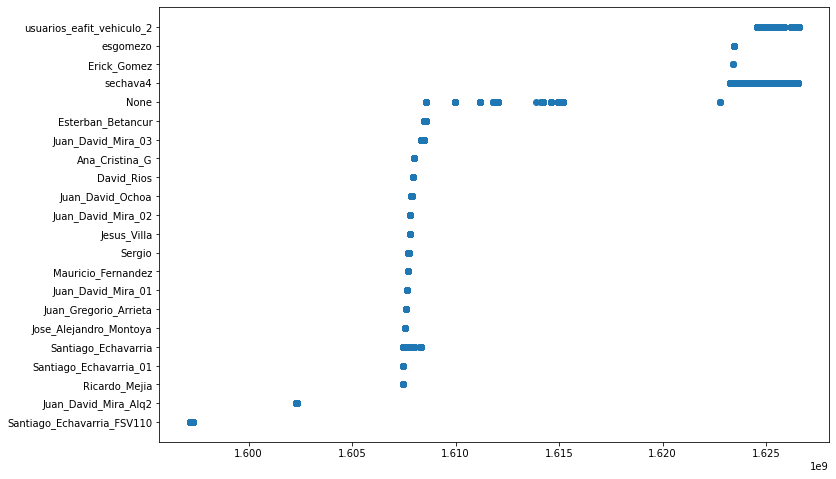

In [97]:
plt.figure(figsize=[12, 8])
plt.scatter(x=loaded_data.timestamp2, y=loaded_data.user_name)

# Segmentation

# Relacion entre pedal de aceleración y potencia


Corr with power =  0.7623115188540774
P value =  5.374267125018729e-145
Corr with current =  0.31745127142421864
P value =  3.296676050663465e-19
Corr with acc =  -0.02804655104379661
P value =  0.440677668699273
len =  758


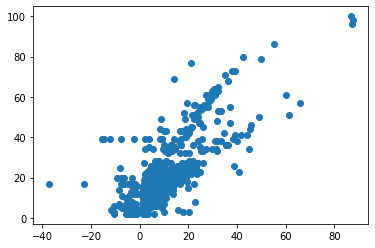

In [98]:
FRV020 = loaded_data[
    (loaded_data['vehicle_id'] == 'FRV020') &
    ((loaded_data['power_kw'] < -1) | (loaded_data['power_kw'] > 1)) &
    (loaded_data['throttle'] > 1) &
    ((loaded_data['throttle'] < 29) | (loaded_data['throttle'] > 31))]
FRV020_esteban = FRV020[FRV020['user_name'] == 'Esteban_Betancur']
plt.figure()
plt.scatter(x=FRV020['power_kw'], y=FRV020['throttle'])

#Correlacion
corr_coef, p_value = stats.pearsonr(FRV020['power_kw'].to_numpy(), FRV020['throttle'])
print('Corr with power = ',corr_coef)
print('P value = ',p_value)

corr_coef_curr, p_value_curr = stats.pearsonr(FRV020['current'].to_numpy(), FRV020['throttle'])
print('Corr with current = ',corr_coef_curr)
print('P value = ',p_value_curr)

corr_coef_acc, p_value_acc = stats.pearsonr(FRV020['mean_acc'].to_numpy(), FRV020['throttle'])
print('Corr with acc = ',corr_coef_acc)
print('P value = ',p_value_acc)
print('len = ',len(FRV020))

In [99]:
features


,mean_acc,prom_abs_acc,std_acc,max_acc,min_acc,skew_acc,mean_current,prom_abs_current,std_current,max_current,...,test_id,end_time,mass,end_odometer,slope_cat,speed_cat,highway_enc,cluster,driving_cluster,road_clusters
0,0.007302,0.019683,0.105292,0.88,-0.68,2.575100e+00,0.945714,0.945714,2.627383,13.28,...,0,2020-08-10 15:17:40,1528.0,2362.00,"(0.0, 2.5]","(0.0, 50.0]",0.084682,1,0,2
1,0.265000,0.325000,0.269676,0.62,-0.12,-1.477654e-01,4.592500,4.592500,0.506625,5.47,...,0,2020-08-10 15:21:57,1528.0,2363.00,"(-2.5, 0.0]","(50.0, 100.0]",0.041982,1,0,3
2,0.113333,0.126667,0.135974,0.30,-0.02,5.280050e-01,4.300000,4.300000,0.000000,4.30,...,0,2020-08-10 15:22:20,1528.0,2364.00,"(-2.5, 0.0]","(50.0, 100.0]",0.041982,1,0,3
3,-0.177500,0.242500,0.253217,0.13,-0.50,-4.872869e-02,5.177500,5.177500,0.323371,5.47,...,0,2020-08-10 15:22:46,1528.0,2364.00,"(0.0, 2.5]","(50.0, 100.0]",0.041982,1,0,3
4,0.332500,0.332500,0.182397,0.57,0.08,-9.941802e-02,4.300000,4.300000,0.000000,4.30,...,0,2020-08-10 15:23:17,1528.0,2365.00,"(0.0, 2.5]","(50.0, 100.0]",0.041982,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,-0.075000,0.145000,0.145000,0.07,-0.22,0.000000e+00,24.750000,24.750000,1.030000,25.78,...,0,2021-07-16 15:15:07,1528.0,5498.72,"(0.0, 2.5]","(50.0, 100.0]",0.048947,1,0,3
5931,-0.086667,0.100000,0.117284,0.02,-0.25,-6.119473e-01,-1.956667,9.710000,11.705390,11.63,...,0,2021-07-17 14:23:03,1528.0,9143.97,"(0.0, 2.5]","(50.0, 100.0]",0.041982,1,0,3
5932,-0.085000,0.215000,0.215000,0.13,-0.30,0.000000e+00,-7.385000,23.195000,23.195000,15.81,...,0,2021-07-17 14:23:10,1528.0,9144.10,"(-2.5, 0.0]","(50.0, 100.0]",0.041982,1,0,3
5933,-0.075000,0.155000,0.155000,0.08,-0.23,2.329191e-16,8.375000,8.375000,4.125000,12.50,...,0,2021-07-17 14:23:24,1528.0,9144.25,"(-2.5, 0.0]","(50.0, 100.0]",0.041982,1,0,3


In [100]:
from sklearn.preprocessing import LabelEncoder  
features = features[features['kms'] <= 1.6]
features = features[features['min_acc'] > -5]
# features = features[(features['max_current'] < 250) ]

# #features = features[(features['traffic_factor'] < 45) ]

# # Cuando es con 1200 mts
features = features[features['consumption'] < 1]

# # Cuando es con 300mts
features = features[(features['consumption'] > -0.5) & (features['consumption'] < 0.6)]

# #features = features[(features['consumption_per_km'] < 0.8) ]

# features = features[features['std_acc'] != 0]

# #Solamente Zoe
# features = features[(features['vehicle_id'] != 'FRV020') & (features['vehicle_id'] != 'FVQ731')]

# features = features[(features['consumption_per_km'] > -4) | (features['consumption_per_km'] < 1) ].dropna()


features.corr()['consumption'].sort_values()


min_acc              -0.125159
end_odometer         -0.090793
mean_soc             -0.084980
speed_ind            -0.069183
traffic_factor       -0.048848
min_speed            -0.048716
nominal_speed        -0.018447
skew_acc             -0.012169
mass                 -0.010047
mean_speed            0.005025
prom_abs_speed        0.005025
highway_enc           0.015578
time                  0.017717
idle_time             0.038429
mean_acc              0.041504
kms                   0.041815
skew_power            0.067073
skew_speed            0.070583
skew_current          0.091256
mean_temp             0.095666
max_speed             0.115411
road_clusters         0.117911
prom_abs_acc          0.127885
max_acc               0.137871
std_acc               0.148519
std_speed             0.198585
std_current           0.214569
std_power             0.302642
prom_abs_current      0.321506
min_power             0.330944
prom_abs_power        0.353289
cluster               0.367364
driving_

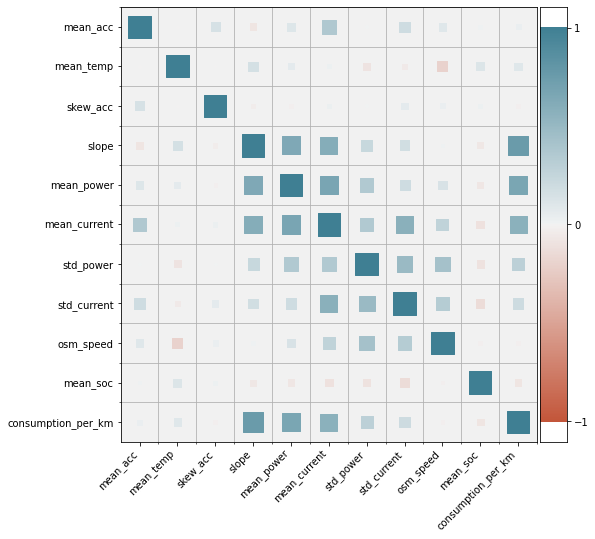

In [101]:
heat_cols = [
    'mean_acc', 'mean_temp',
    'skew_acc', 'slope',
    'mean_power','mean_current', 'std_power','std_current',
    'osm_speed', 'mean_soc',
    'consumption_per_km'
]

a = features.copy()
a = a.rename(columns={'mean_speed':'osm_speed'})
corr=a[heat_cols].corr()
plt.figure(figsize=(8,8))
corrplot(corr.sort_values(['slope']), size_scale=500);

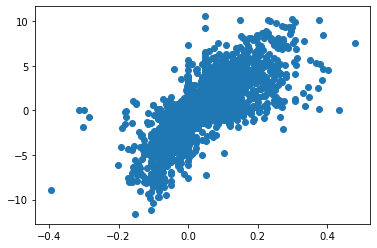

In [111]:
plt.scatter(x=features.consumption, y=features.slope)

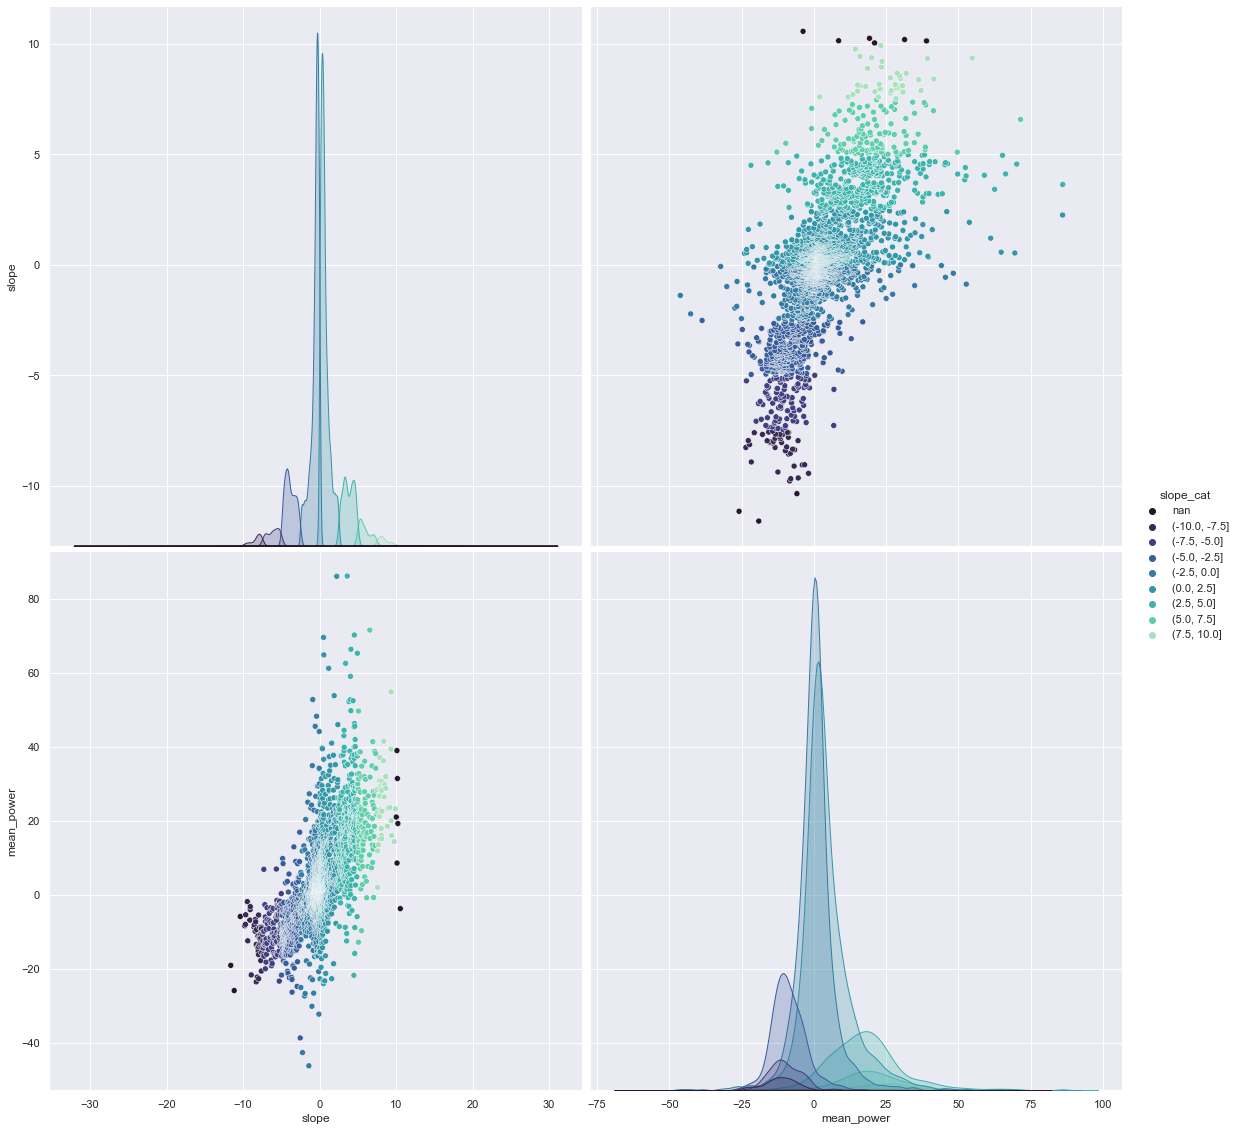

In [119]:
a = a[a['mean_power']!= 0]
sns.pairplot(a.dropna().sort_values(['slope']), hue='slope_cat', palette='mako', vars=[
#     'min_acc',
    'slope',
    'mean_power',
#     'osm_speed',
#     'consumption_per_km'
], kind= 'scatter', height=8)

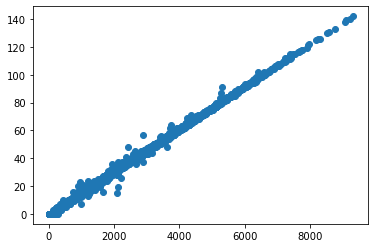

In [103]:
rpm = loaded_data[loaded_data.rpm > 0]
plt.scatter(x=rpm.rpm, y=rpm.speed)


# To implement - pace during route
### TellsF the user if his current rate is lower or upper to the estimated

In [104]:
features

,mean_acc,prom_abs_acc,std_acc,max_acc,min_acc,skew_acc,mean_current,prom_abs_current,std_current,max_current,...,test_id,end_time,mass,end_odometer,slope_cat,speed_cat,highway_enc,cluster,driving_cluster,road_clusters
0,0.007302,0.019683,0.105292,0.88,-0.68,2.575100e+00,0.945714,0.945714,2.627383,13.28,...,0,2020-08-10 15:17:40,1528.0,2362.00,"(0.0, 2.5]","(0.0, 50.0]",0.084682,1,0,2
1,0.265000,0.325000,0.269676,0.62,-0.12,-1.477654e-01,4.592500,4.592500,0.506625,5.47,...,0,2020-08-10 15:21:57,1528.0,2363.00,"(-2.5, 0.0]","(50.0, 100.0]",0.041982,1,0,3
2,0.113333,0.126667,0.135974,0.30,-0.02,5.280050e-01,4.300000,4.300000,0.000000,4.30,...,0,2020-08-10 15:22:20,1528.0,2364.00,"(-2.5, 0.0]","(50.0, 100.0]",0.041982,1,0,3
3,-0.177500,0.242500,0.253217,0.13,-0.50,-4.872869e-02,5.177500,5.177500,0.323371,5.47,...,0,2020-08-10 15:22:46,1528.0,2364.00,"(0.0, 2.5]","(50.0, 100.0]",0.041982,1,0,3
4,0.332500,0.332500,0.182397,0.57,0.08,-9.941802e-02,4.300000,4.300000,0.000000,4.30,...,0,2020-08-10 15:23:17,1528.0,2365.00,"(0.0, 2.5]","(50.0, 100.0]",0.041982,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,-0.075000,0.145000,0.145000,0.07,-0.22,0.000000e+00,24.750000,24.750000,1.030000,25.78,...,0,2021-07-16 15:15:07,1528.0,5498.72,"(0.0, 2.5]","(50.0, 100.0]",0.048947,1,0,3
5931,-0.086667,0.100000,0.117284,0.02,-0.25,-6.119473e-01,-1.956667,9.710000,11.705390,11.63,...,0,2021-07-17 14:23:03,1528.0,9143.97,"(0.0, 2.5]","(50.0, 100.0]",0.041982,1,0,3
5932,-0.085000,0.215000,0.215000,0.13,-0.30,0.000000e+00,-7.385000,23.195000,23.195000,15.81,...,0,2021-07-17 14:23:10,1528.0,9144.10,"(-2.5, 0.0]","(50.0, 100.0]",0.041982,1,0,3
5933,-0.075000,0.155000,0.155000,0.08,-0.23,2.329191e-16,8.375000,8.375000,4.125000,12.50,...,0,2021-07-17 14:23:24,1528.0,9144.25,"(-2.5, 0.0]","(50.0, 100.0]",0.041982,1,0,3


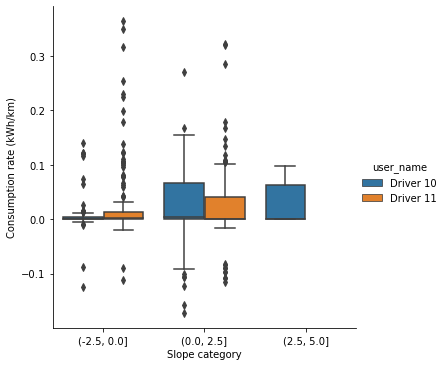

In [107]:
x=features.copy() ##[(features['slope'] > -5) & (features['slope'] < 5)]
# x['slope_cat'] = pd.cut(x["slope"], np.arange(-5.1,5.2,3.4) )
x = x[x['consumption_per_km'] > -0.2]

x = x[x['user_name'] != 'Juan_David_Mira_01']
x = x[x['user_name'] != 'Santiago_Echavarria_FSV110']

x = x[x['user_name'] != 'Santiago_Echavarria']
x = x[x['user_name'] != 'Santiago_Echavarria_01']  # Por ser muy atipico
x = x[x['user_name'] != 'Juan_David_Mira_01']
x = x[x['user_name'] != 'Juan_David_Mira_02']
x = x[x['user_name'] != 'Juan_David_Mira_03']
x = x[x['user_name'] != 'Juan_David_Mira_Alq2']

x.loc[x['user_name'] == 'Ricardo_Mejia', 'user_name'] = 'Driver 0'
x.loc[x['user_name'] == 'Jose_Alejandro_Montoya', 'user_name'] = 'Driver 1'
x.loc[x['user_name'] == 'Juan_Gregorio_Arrieta', 'user_name'] = 'Driver 2'
x.loc[x['user_name'] == 'Mauricio_Fernandez', 'user_name'] = 'Driver 3'
x.loc[x['user_name'] == 'Sergio', 'user_name'] = 'Driver 4'
x.loc[x['user_name'] == 'Jesus_Villa', 'user_name'] = 'Driver 5'
x.loc[x['user_name'] == 'Juan_David_Ochoa', 'user_name'] = 'Driver 6'
x.loc[x['user_name'] == 'David_Rios', 'user_name'] = 'Driver 7'
x.loc[x['user_name'] == 'Ana_Cristina_G', 'user_name'] = 'Driver 8'
x.loc[x['user_name'] == 'Esterban_Betancur', 'user_name'] = 'Driver 9'
x.loc[x['user_name'] == 'usuarios_eafit_vehiculo_2', 'user_name'] = 'Driver 10'
x.loc[x['user_name'] == 'sechava4', 'user_name'] = 'Driver 11'


x = x[(x['user_name'] == 'Driver 10') | (x['user_name'] == 'Driver 11')]
x.rename(columns={"mean_power": "MBPO (kW)","mean_speed": "Nominal speed (km/h)",
                                       'consumption_per_km': 'Consumption rate (kWh/km)','slope_cat':'Slope category'}, inplace=True)


sns.catplot(x='Slope category', y='Consumption rate (kWh/km)', hue='user_name', data=x.sort_values(by=['user_name', 'slope' ]), kind='box')

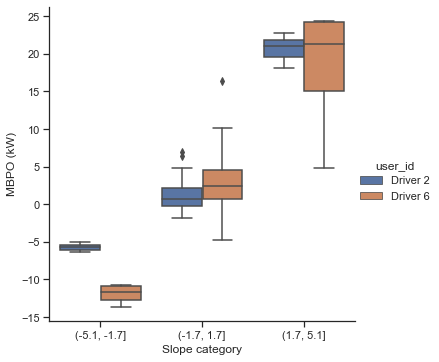

In [90]:
sns.catplot(x='Slope category', y="MBPO (kW)", hue='user_name', data=x.sort_values(by=['user_name', 'slope' ]), kind='box')

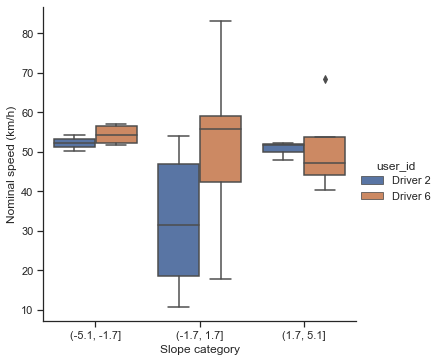

In [91]:
sns.catplot(x='Slope category', y='Nominal speed (km/h)', hue='user_name', data=x.sort_values(by=['user_name', 'slope' ]), kind='box')

In [95]:
from   scipy import stats

x1=x[(x['slope'] > 2) ]
x2=x[(x['slope'] > -2) & (x['slope'] <= 2)]

stat, p, med, tbl = stats.median_test(x1['Consumption rate (kWh/km)'][(x1['user_name'] == 'Driver 2')],
                                      x1['Consumption rate (kWh/km)'][(x1['user_name'] == 'Driver 6')])
print('p = ' + str(p), '\n')

# Different slope group
t2, p2 = stats.ttest_ind(x1['Consumption rate (kWh/km)'][(x1['user_name'] == 'Driver 2')] ,
                         x2['Consumption rate (kWh/km)'][x2['user_name'] == 'Driver 6' ])
print('For same user - different slope group')
print('t = ' + str(t2))
print('p = ' + str(p2), '\n')

# Same slope group > 1.7
t2, p2 = stats.ttest_ind(x1['Consumption rate (kWh/km)'][(x1['user_name'] == 'Driver 2')] ,
                         x1['Consumption rate (kWh/km)'][x1['user_name'] == 'Driver 6' ])
print('For 2 different users - slope group > 2')
print('t = ' + str(t2))
print('p = ' + str(p2), '\n')

# Same slope group > 1.7
t2, p2 = stats.ttest_ind(x1['Nominal speed (km/h)'][(x1['user_name'] == 'Driver 2')] ,
                         x1['Nominal speed (km/h)'][x1['user_name'] == 'Driver 6' ])
print('Nominal speed (km/h) For 2 different users - slope group > 2')
print('t = ' + str(t2))
print('p = ' + str(p2), '\n')

# Same slope group > 1.7
t2, p2 = stats.ttest_ind(x1['MBPO (kW)'][(x1['user_name'] == 'Driver 2')] ,
                         x1['MBPO (kW)'][x1['user_name'] == 'Driver 6' ])
print('MBPO (kW) For 2 different users - slope group > 2')
print('t = ' + str(t2))
print('p = ' + str(p2), '\n')

p = 0.7408568142938687 

For same user - different slope group
t = 7.342105350759149
p = 1.8099632787115323e-07 

For 2 different users - slope group > 2
t = 0.424050026782221
p = 0.689154707697324 

Nominal speed (km/h) For 2 different users - slope group > 2
t = -0.02190351379570013
p = 0.983372154722483 

MBPO (kW) For 2 different users - slope group > 2
t = 0.4831998295634717
p = 0.6493695623751345 



# Separate 25 km for measuring and rest for test (for the test cases)


In [118]:
features['cumdist1'] = features[(features['user_name'] == 'Santiago_Echavarria') ].kms.cumsum()  #features['cumdist'] 
features.loc[features['cumdist1'] > 70, 'user_name'] = 'Santiago_Echavarria_test'
features.loc[features['cumdist1'] < 70, 'user_name'] = 'Santiago_Echavarria_measure'

### Se utiliza para train los datos de las pruebas contraladas de todos los usuariois

In [119]:
train = features[(features['user_name'] != 'Santiago_Echavarria_test') &
                 (features['user_name'] != 'Santiago_Echavarria_measure')]
test = features.loc[features.index.difference(train.index)]


In [120]:
train.user_name.unique()

array(['Santiago_Echavarria_FSV110', 'Juan_David_Mira_Alq2',
       'Ricardo_Mejia', 'Santiago_Echavarria_01',
       'Jose_Alejandro_Montoya', 'Juan_Gregorio_Arrieta',
       'Juan_David_Mira_01', 'Mauricio_Fernandez', 'Sergio',
       'Jesus_Villa', 'Juan_David_Mira_02', 'Juan_David_Ochoa',
       'David_Rios', 'Ana_Cristina_G', 'Juan_David_Mira_03',
       'Esterban_Betancur'], dtype=object)

# Slope groups

In [121]:
slope_groups = train.groupby(by=["slope_cat"])

mean_features_by_slope = slope_groups[['mean_power', 'min_acc', 'consumption_per_km']].mean().reset_index()
mean_features_by_slope.rename(columns={
    "mean_power": "mean_power_by_slope", 
    "min_acc": "mean_min_acc",
    'consumption_per_km': 'mean_consumption_per_km',
    'slope':'slope_cat'
}, inplace=True)

mean_features_by_slope.to_csv('UserDrivingData/mean_features_by_slope.csv', index=False)


#Se lee la que se saco con segmentos de 300m.
mean_features_by_slope = pd.read_csv('UserDrivingData/mean_features_by_slope.csv')
mean_features_by_slope['slope_cat'] = mean_features_by_slope['slope_cat'].astype('string')


train_cons = pd.merge(left=train, right=mean_features_by_slope,
                      left_on='slope_cat', right_on='slope_cat')

train_cons['user_name'].unique()

array(['Santiago_Echavarria_FSV110', 'Juan_David_Mira_Alq2',
       'Ricardo_Mejia', 'Santiago_Echavarria_01',
       'Jose_Alejandro_Montoya', 'Juan_Gregorio_Arrieta',
       'Juan_David_Mira_01', 'Mauricio_Fernandez', 'Sergio',
       'Jesus_Villa', 'Juan_David_Mira_02', 'Juan_David_Ochoa',
       'David_Rios', 'Ana_Cristina_G', 'Juan_David_Mira_03',
       'Esterban_Betancur'], dtype=object)

# User and slope groups

In [123]:
user_slope_groups = train.groupby(by=['slope_cat', 'user_name'])
mean_features_by_user_and_slope = user_slope_groups[['mean_power', 'min_acc', 'consumption_per_km']].mean().reset_index()
mean_features_by_user_and_slope.rename(columns={
    "mean_power": "mean_power_usr",
    "min_acc": "mean_min_acc_usr",
    'consumption_per_km': 'mean_consumption_per_km_usr'
}, inplace=True)

mean_features_by_user_and_slope
mean_features_by_user_and_slope.to_csv('UserDrivingData/mean_features_by_user_and_slope.csv', index=False)


#Se lee la que se saco con segmentos de 300m.
mean_features_by_user_and_slope = pd.read_csv('UserDrivingData/mean_features_by_user_and_slope.csv')
mean_features_by_user_and_slope['slope_cat'] = mean_features_by_user_and_slope['slope_cat'].astype('string')

train_cons = pd.merge(left=train_cons, right=mean_features_by_user_and_slope,
                              left_on=['user_name', 'slope_cat'], right_on=['user_name', 'slope_cat'])

# Esta tabla se sacó con segmentos de 300m
mean_features_by_user_and_slope.tail(60)

,slope_cat,user_id,mean_power_usr,mean_min_acc_usr,mean_consumption_per_km_usr
10,"(-2.5, 0.0]",Juan_Gregorio_Arrieta,-0.618424,-1.006667,0.020451
11,"(-2.5, 0.0]",Mauricio_Fernandez,-1.809018,-0.822222,0.018010
12,"(-2.5, 0.0]",Ricardo_Mejia,0.312449,-0.540000,0.011797
13,"(-2.5, 0.0]",Santiago_Echavarria_01,6.145579,-1.013750,0.068506
14,"(-2.5, 0.0]",Santiago_Echavarria_FSV110,1.702068,-0.905714,0.045869
15,"(-2.5, 0.0]",Sergio,0.246073,-0.839286,0.037600
16,"(-5.0, -2.5]",Ana_Cristina_G,-7.655444,-0.840000,-0.214334
17,"(-5.0, -2.5]",David_Rios,-10.281630,-0.373333,-0.160224
18,"(-5.0, -2.5]",Esterban_Betancur,-10.141663,-0.750000,-0.172669
19,"(-5.0, -2.5]",Jose_Alejandro_Montoya,-8.258067,-0.272500,-0.167208


In [125]:
# cols = ['max_power','slope']
cols = ['mean_power_usr', 'mean_min_acc_usr', 'mean_speed', 'slope']
model_ft = train_cons[cols]
selected_ft = train_cons[['mean_power_usr', 'mean_min_acc_usr', 'mean_speed', 'slope', 'consumption_per_km']]

print(len(selected_ft))

selected_ft.corr()

629


,mean_power_usr,mean_min_acc_usr,mean_speed,slope,consumption_per_km
mean_power_usr,1.000000,-0.267806,-0.020825,0.925231,0.857660
mean_min_acc_usr,-0.267806,1.000000,-0.031887,-0.314168,-0.295193
mean_speed,-0.020825,-0.031887,1.000000,-0.054162,0.021038
slope,0.925231,-0.314168,-0.054162,1.000000,0.887983
consumption_per_km,0.857660,-0.295193,0.021038,0.887983,1.000000


# Scaling

In [145]:
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

# For other sklearn models differente than linear regression
scaler = MinMaxScaler()
scaler.fit(train_cons[selected_ft.columns])

# For linear regression
scaler_lm = MinMaxScaler()
scaler_lm.fit(train_cons[model_ft.columns])

train_scaled = pd.DataFrame(scaler.transform(train_cons[selected_ft.columns]), columns=selected_ft.columns)

train_lm_scaled = pd.DataFrame(scaler_lm.transform(train_cons[model_ft.columns]), columns=model_ft.columns)
train_lm_scaled['consumption_per_km'] = train_scaled['consumption_per_km']

# Linear Model

In [127]:
formula = 'consumption_per_km ~ mean_power_usr + mean_min_acc_usr + mean_speed + slope -1' # 0.84
#formula = 'consumption_per_km ~ slope + max_power -1' # 0.84


lm_consumo = ols(formula = formula, data = train_cons[selected_ft.columns]).fit()
print(lm_consumo.summary())

                                 OLS Regression Results                                
Dep. Variable:     consumption_per_km   R-squared (uncentered):                   0.837
Model:                            OLS   Adj. R-squared (uncentered):              0.836
Method:                 Least Squares   F-statistic:                              804.7
Date:                Thu, 27 May 2021   Prob (F-statistic):                   7.92e-245
Time:                        23:15:43   Log-Likelihood:                          664.86
No. Observations:                 629   AIC:                                     -1322.
Df Residuals:                     625   BIC:                                     -1304.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

<Figure size 1440x1440 with 0 Axes>

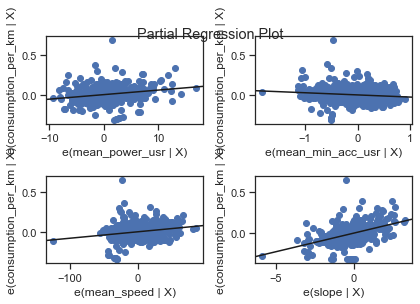

In [128]:
plt.figure(figsize =[20,20])
fig=sm.graphics.plot_partregress_grid(lm_consumo)


# Test case :

Aqui dividimos el set de validación en 2 partes: Santiago_Echavarria_measure y Santiago_Echavarria_test.
Santiago_Echavarria_measure contiene 25 km de manejo y se utilizará para determinar los promedios de las conductas de usuario. El conjunto Santiago_Echavarria_test contiene los siguientes kilómetros y será el conjunto donde se aplicará el algoritmo basado en los promedios calculados de Santiago_Echavarria_measure.


In [129]:


test_test = test[test['user_name']=='Santiago_Echavarria_test']
test_measure = test[test['user_name']=='Santiago_Echavarria_measure']


print(len(test_test))
print(len(test_measure))


slope_user_groups = test_measure.groupby(by=['slope_cat', 'user_name'])
mean_features_by_user_and_slope = slope_user_groups[['mean_power', 'min_acc', 'consumption_per_km']].mean().reset_index()
mean_features_by_user_and_slope.rename(columns={
    "mean_power": "mean_power_usr",
    "min_acc": "mean_min_acc_usr",
    'consumption_per_km': 'mean_consumption_per_km_usr'
}, inplace=True)

mean_features_by_user_and_slope.user_name = 'Santiago_Echavarria_test'
test_test = pd.merge(how='left', left=test_test, right=mean_features_by_user_and_slope,
                              left_on=['user_name', 'slope_cat'], right_on=['user_name', 'slope_cat'])
test_test

8
55


,mean_acc,prom_abs_acc,std_acc,max_acc,min_acc,skew_acc,mean_current,prom_abs_current,std_current,max_current,...,speed_ind,test_id,end_time,mass,end_odometer,slope_cat,cumdist1,mean_power_usr,mean_min_acc_usr,mean_consumption_per_km_usr
0,0.000909,0.448182,0.588565,1.03,-1.31,-0.502120,52.726364,62.648182,61.610605,200.83,...,0.446429,0,2020-12-18 15:18:49,1626,748.0,"(2.5, 5.0]",70.758006,18.560005,-0.952222,0.352160
1,-0.095000,0.701000,0.800903,1.04,-1.18,0.160915,-23.839000,42.783000,46.626471,44.79,...,0.581395,0,2020-12-18 15:22:09,1626,748.0,"(-5.0, -2.5]",72.328361,-12.473495,-0.298889,-0.206881
2,-0.109286,0.430714,0.625830,0.67,-1.86,-1.499028,-38.607143,40.797143,56.950161,15.33,...,0.675676,0,2020-12-18 15:23:17,1626,748.0,"(-5.0, -2.5]",73.600177,-12.473495,-0.298889,-0.206881
3,0.236364,0.380000,0.513124,1.43,-0.38,1.057402,1.304545,50.950000,65.222948,151.00,...,0.413223,0,2020-12-18 15:24:21,1626,748.0,"(-5.0, -2.5]",74.837188,-12.473495,-0.298889,-0.206881
4,-0.205000,0.385000,0.438092,0.36,-0.87,-0.336818,-37.875000,37.875000,36.037431,-7.00,...,0.684932,0,2020-12-18 15:25:39,1626,748.0,"(-5.0, -2.5]",76.042728,-12.473495,-0.298889,-0.206881
5,-0.042308,0.270000,0.331782,0.57,-0.55,-0.099723,-3.150000,12.043846,18.617060,19.86,...,0.722892,0,2020-12-18 15:41:56,1626,748.0,"(-2.5, 0.0]",77.290244,0.211450,-0.886000,0.000672
6,0.067292,0.282292,0.377843,0.89,-0.98,-0.329823,4.877083,5.892083,8.443526,38.92,...,1.538462,0,2020-12-18 15:59:03,1626,748.0,"(0.0, 2.5]",78.502274,4.169887,-0.715000,0.140953
7,0.010000,0.381875,0.493438,1.32,-0.95,0.557153,8.166875,11.676250,16.779621,68.25,...,1.304348,0,2020-12-18 16:18:36,1626,748.0,"(0.0, 2.5]",79.708626,4.169887,-0.715000,0.140953


In [130]:
test_test = pd.merge(how='left', left=test_test, right=mean_features_by_slope,
                     left_on=['slope_cat'], right_on=['slope_cat'])

test_test


,mean_acc,prom_abs_acc,std_acc,max_acc,min_acc,skew_acc,mean_current,prom_abs_current,std_current,max_current,...,mass,end_odometer,slope_cat,cumdist1,mean_power_usr,mean_min_acc_usr,mean_consumption_per_km_usr,mean_power_by_slope,mean_min_acc,mean_consumption_per_km
0,0.000909,0.448182,0.588565,1.03,-1.31,-0.502120,52.726364,62.648182,61.610605,200.83,...,1626,748.0,"(2.5, 5.0]",70.758006,18.560005,-0.952222,0.352160,18.591871,-0.757093,0.328237
1,-0.095000,0.701000,0.800903,1.04,-1.18,0.160915,-23.839000,42.783000,46.626471,44.79,...,1626,748.0,"(-5.0, -2.5]",72.328361,-12.473495,-0.298889,-0.206881,-8.998501,-0.402727,-0.158759
2,-0.109286,0.430714,0.625830,0.67,-1.86,-1.499028,-38.607143,40.797143,56.950161,15.33,...,1626,748.0,"(-5.0, -2.5]",73.600177,-12.473495,-0.298889,-0.206881,-8.998501,-0.402727,-0.158759
3,0.236364,0.380000,0.513124,1.43,-0.38,1.057402,1.304545,50.950000,65.222948,151.00,...,1626,748.0,"(-5.0, -2.5]",74.837188,-12.473495,-0.298889,-0.206881,-8.998501,-0.402727,-0.158759
4,-0.205000,0.385000,0.438092,0.36,-0.87,-0.336818,-37.875000,37.875000,36.037431,-7.00,...,1626,748.0,"(-5.0, -2.5]",76.042728,-12.473495,-0.298889,-0.206881,-8.998501,-0.402727,-0.158759
5,-0.042308,0.270000,0.331782,0.57,-0.55,-0.099723,-3.150000,12.043846,18.617060,19.86,...,1626,748.0,"(-2.5, 0.0]",77.290244,0.211450,-0.886000,0.000672,0.421340,-0.883081,0.028696
6,0.067292,0.282292,0.377843,0.89,-0.98,-0.329823,4.877083,5.892083,8.443526,38.92,...,1626,748.0,"(0.0, 2.5]",78.502274,4.169887,-0.715000,0.140953,4.701393,-0.882838,0.125152
7,0.010000,0.381875,0.493438,1.32,-0.95,0.557153,8.166875,11.676250,16.779621,68.25,...,1626,748.0,"(0.0, 2.5]",79.708626,4.169887,-0.715000,0.140953,4.701393,-0.882838,0.125152


In [131]:
test_test[['user_name', 'slope_cat']] = test_test[['user_name', 'slope_cat']].astype('string')

In [67]:
#mean_max_pot_per_user_and_slope['slope_cat'] = mean_max_pot_per_user_and_slope['slope_cat'].astype('string')

In [68]:
# test_consolidated = pd.merge(how='left', left=test_consolidated, right=mean_max_pot_per_user_and_slope,
#                               left_on=['slope_cat', 'user_name'], right_on=['slope_cat', 'user_name'])
# test_consolidated

In [133]:
test_test['mean_power_usr'] = test_test.apply(
    lambda row: row['mean_power_by_slope'] if np.isnan(row['mean_power_usr']) else row['mean_power_usr'],
    axis=1
)
test_test['mean_min_acc_usr'] = test_test.apply(
    lambda row: row['mean_min_acc'] if np.isnan(row['mean_min_acc_usr']) else row['mean_min_acc_usr'],
    axis=1
)
test_test['mean_consumption_per_km_usr'] = test_test.apply(
    lambda row: row['mean_consumption_per_km'] if np.isnan(row['mean_consumption_per_km_usr']) else row['mean_consumption_per_km_usr'],
    axis=1
)
test_test.isna().sum()

mean_acc                       0
prom_abs_acc                   0
std_acc                        0
max_acc                        0
min_acc                        0
skew_acc                       0
mean_current                   0
prom_abs_current               0
std_current                    0
max_current                    0
min_current                    0
skew_current                   0
mean_power                     0
prom_abs_power                 0
std_power                      0
max_power                      0
min_power                      0
skew_power                     0
mean_speed                     0
prom_abs_speed                 0
std_speed                      0
max_speed                      0
min_speed                      0
skew_speed                     0
kms                            0
consumption_per_km             0
consumption                    0
highway                        0
slope                          0
nominal_speed                  0
mean_soc  

In [134]:
print(test_test[cols].isna().sum() )

test_scaled = pd.DataFrame(
    scaler_lm.transform(
        test_test[model_ft.columns]
    ), columns=model_ft.columns)

test_scaled[cols].isna().sum()


mean_power_usr      0
mean_min_acc_usr    0
mean_speed          0
slope               0
dtype: int64


mean_power_usr      0
mean_min_acc_usr    0
mean_speed          0
slope               0
dtype: int64

In [135]:
y_test = pd.DataFrame(
    scaler.transform(
        test_test[selected_ft.columns]
    ), columns=selected_ft.columns
)['consumption_per_km']

predictions = lm_consumo.predict(test_scaled)



### Without scaling

In [136]:
test_test['consumption_per_km'] = test_test['consumption_per_km']
predictions = lm_consumo.predict(test_test[cols])
y_test_lm = test_test['consumption_per_km']

In [137]:
dump(lm_consumo, open('UserDrivingData/linear_model.pkl', 'wb'))

RMSE = 0.07116143413677326
RMSPE = 423.8073089944104
RME = 195.03517679727045
R2 = 0.8486401428363286
max error= 0.11092486980917321


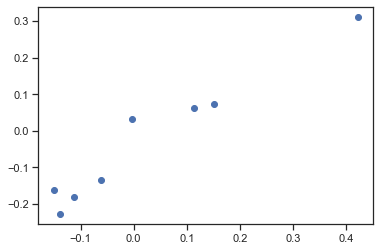

In [138]:
def model_evaluation(y_test, predictions):
    RMSE = np.sqrt(mean_squared_error(y_test, predictions))
    print('RMSE =',RMSE)
    
    rmspe = (np.sqrt(np.mean(np.square((y_test - predictions) / y_test)))) * 100
    print('RMSPE =',rmspe)
    
    rme = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    print('RME =',rme)


    print('R2 =',r2_score(y_test, predictions))
    print('max error=',max(abs(y_test - predictions)))
    plt.figure()
    plt.scatter(x=y_test, y=predictions)

model_evaluation(y_test_lm, predictions)

# Random forest

RMSE = 0.044885001584901656
RMSPE = 9.525379326715688
RME = 8.532452028166503
R2 = 0.9103858460967591
max error= 0.0981916965261338


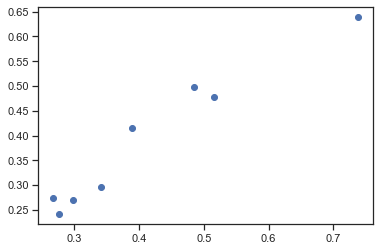

In [139]:
X = train_lm_scaled[cols].values
y = train_lm_scaled['consumption_per_km'].values

# Step 1
# n_estimators=[,,,,,], max_depth=[,,,,,,]

# Curva de aprendizaje
# Variar train size 

# Curva de complejidad
# x cada uno de los parámetros max_depth': 110, 'max_samples': 0.2, 'n_estimators': 45}
randF_regr = RandomForestRegressor(n_estimators=149, max_depth=5,
                                   random_state=0,max_features='auto' , criterion='mse', max_samples = 0.219)

randF_regr.fit(X, y)
y_pred = randF_regr.predict(test_scaled[cols].values)

model_evaluation(y_test, y_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
print("Initialize Grid Search")
param_grid = { 
    'n_estimators': np.arange(5,70,5),
    'max_depth' : np.arange(2,20,2),
    'max_samples' : np.arange(0.1,0.9,0.1)
}
# create and fit a regression model, testing each parameter value

 

model = RandomForestRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

# Complexity curves

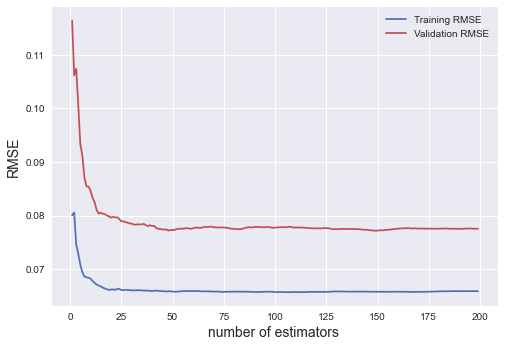

In [167]:
from sklearn.metrics import mean_absolute_error

n_estimators = np.arange(1,200,1)
X_test = test_scaled[cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for estimators in n_estimators:
    reg = RandomForestRegressor(n_estimators = estimators, max_features='auto', max_depth=5, max_samples = 0.219,
                                criterion = 'mse', random_state = 0)
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(n_estimators, train_acc, 'b', label = 'Training RMSE')
plt.plot(n_estimators, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('number of estimators ', fontsize = 14)
# plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [168]:
n_estimators[val_acc.index(min(val_acc))]


149

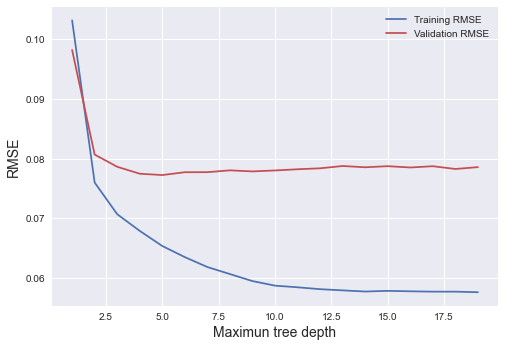

In [160]:
depths = np.arange(1,20,1)
X_test = test_scaled[cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for depth in depths:
    reg = RandomForestRegressor(n_estimators = 48, max_features='auto', max_samples = 0.219,
                                max_depth=depth, criterion = 'mse', random_state = 0, n_jobs=-1)
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(depths, train_acc, 'b', label = 'Training RMSE')
plt.plot(depths, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Maximun tree depth', fontsize = 14)
# plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [161]:
depths[val_acc.index(min(val_acc))]


5

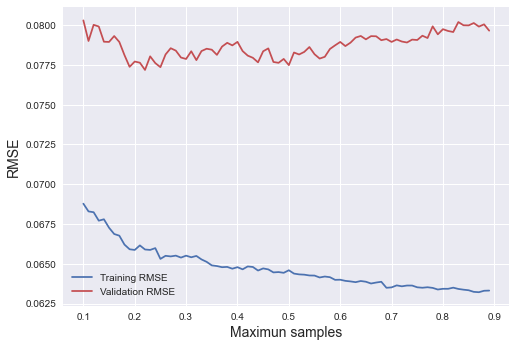

In [162]:
max_samples = np.arange(0.1,0.9,0.01)
X_test = test_scaled[cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for max_sample in max_samples:
    reg = RandomForestRegressor(n_estimators = 48, max_features='auto', max_samples = max_sample,
                                max_depth=5, criterion = 'mse', random_state = 0, n_jobs=-1)
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(max_samples, train_acc, 'b', label = 'Training RMSE')
plt.plot(max_samples, val_acc, 'r', label = 'Validation RMSE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Maximun samples', fontsize = 14)
# plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [163]:
max_samples[val_acc.index(min(val_acc))]

0.21999999999999995

Text(0.5, 0, 'Relative Importance')

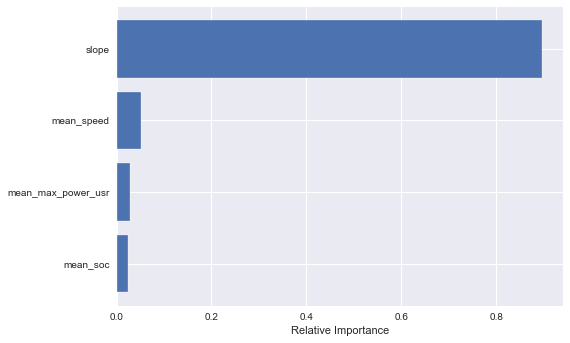

In [520]:
features=train_lm_scaled.columns[[0, 1, 2, 3]]
importances = randF_regr.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
#plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [140]:
dump(randF_regr, open('MachineLearningModels/randomForest_0_3_mean_consumption_maxerr_model.pkl', 'wb'))
dump(scaler, open('MachineLearningModels/scaler.pkl', 'wb'))
dump(scaler_lm, open('MachineLearningModels/scaler_lm.pkl', 'wb'))

# XGBoost

RMSE = 0.051668786051395306
RMSPE = 10.939509516329712
RME = 9.167645534307004
R2 = 0.8812508157216299
max error= 0.12042840182758996


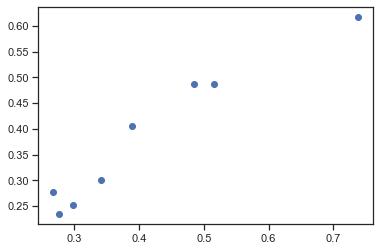

In [141]:
## 
data_dmatrix = xgb.DMatrix(data=X,label=y)

# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 0.5,
#                 max_depth = 10, n_estimators = 5)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7, learning_rate = 0.3,
                max_depth = 2, n_estimators = 41)


xg_reg.fit(X, y)

y_pred_xgb = xg_reg.predict(test_scaled[cols].values)
model_evaluation(y_test, y_pred_xgb)

# Save the model
dump(xg_reg, open('MachineLearningModels/xg_reg_model.pickle.dat', 'wb'))


In [115]:
from sklearn.model_selection import RandomizedSearchCV
print("Initialize Grid Search")
param_distributions = { 
    'colsample_bytree' : np.arange(0.1, 1, 0.1),
    'learning_rate' : np.arange(0.1, 1, 0.1),
    'n_estimators': [2,3,4,5],
    'max_depth' : np.arange(10, 30, 2),
    'objective' :['reg:squarederror']
}
# create and fit a regression model, testing each parameter value

 
#     'n_estimators': np.arange(3,60,1),
#     'max_depth' : np.arange(3,40,1),
model = xgb.XGBRegressor()
grid = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_jobs=-1)
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

Initialize Grid Search
RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          vali

In [142]:
n_estimators = np.arange(2,50,1)
X_test = test_scaled[cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for estimators in n_estimators:
    
    reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.75, learning_rate = 0.3,
                max_depth = 2, n_estimators = estimators, n_jobs=-1)

    
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(n_estimators, train_acc, 'b', label = 'Training RMSE')
plt.plot(n_estimators, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('number of estimators ', fontsize = 14)
#plt.title('Complexity curves for xgboost', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

NameError: name 'mean_absolute_error' is not defined

In [127]:
# El valor óptimo
n_estimators[val_acc.index(min(val_acc))]

19

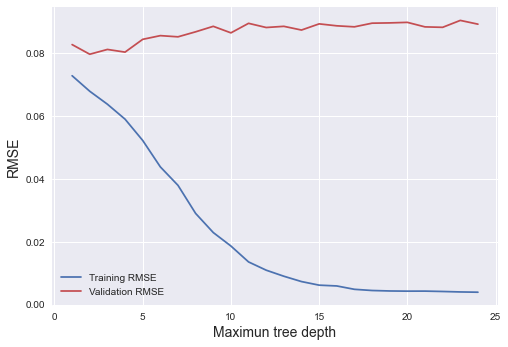

In [134]:
depths = np.arange(1,25,1)
X_test = test_scaled[cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for depth in depths:
    
    reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.75, learning_rate = 0.3,
                max_depth = depth, n_estimators = 19, n_jobs=-1) 
    
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(depths, train_acc, 'b', label = 'Training RMSE')
plt.plot(depths, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Maximun tree depth', fontsize = 14)
#plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [133]:
depths[val_acc.index(min(val_acc))]

17

#### Percentage of columns samples by tree

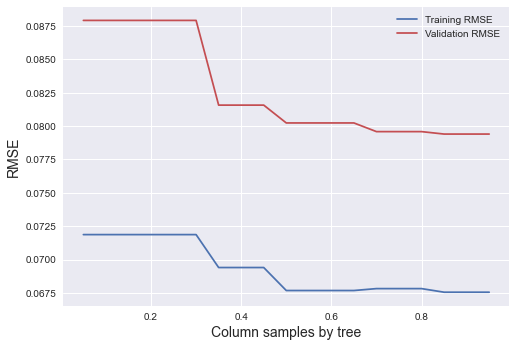

In [135]:
colsamples_bytree = np.arange(0.05,1,0.05)
X_test = test_scaled[cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for colsample_bytree in colsamples_bytree:
    
    reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = colsample_bytree, learning_rate = 0.3,
                max_depth = 2, n_estimators = 19, n_jobs=-1) 
    
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(colsamples_bytree, train_acc, 'b', label = 'Training RMSE')
plt.plot(colsamples_bytree, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Column samples by tree', fontsize = 14)
#plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [121]:
colsamples_bytree[val_acc.index(min(val_acc))]

0.7000000000000001

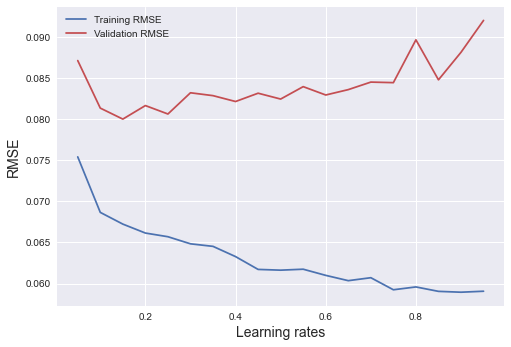

In [138]:
learning_rates = np.arange(0.05,1,0.05)
X_test = test_scaled[cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for learning_rate in learning_rates:
    
    reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = learning_rate,
                max_depth = 2, n_estimators = 41, n_jobs=-1) 
    
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(learning_rates, train_acc, 'b', label = 'Training RMSE')
plt.plot(learning_rates, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Learning rates', fontsize = 14)
#plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [139]:
learning_rates[val_acc.index(min(val_acc))]

0.15000000000000002

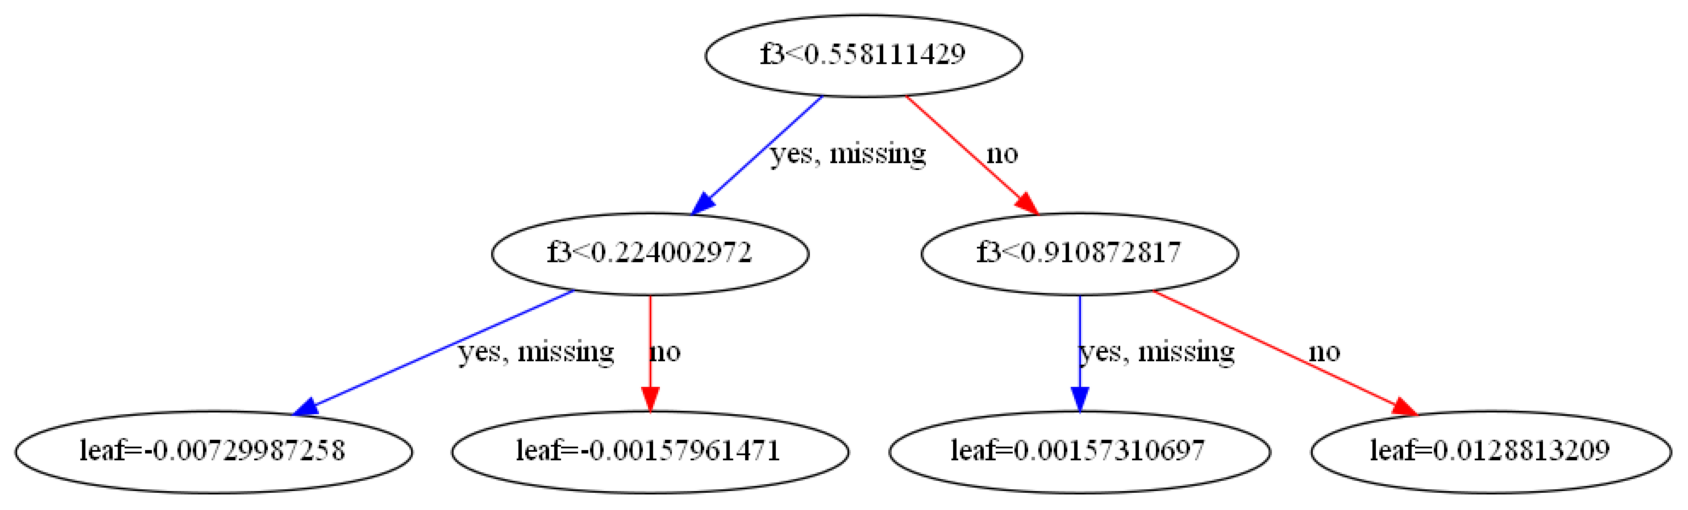

In [102]:
ax = xgb.plot_tree(xg_reg,num_trees=17)
fig = ax.figure
fig.set_size_inches(30, 35)
# fig = plot.get_figure()
# fig.savefig('test2png.png')

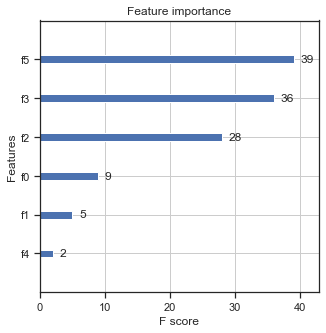

In [42]:
ax = xgb.plot_importance(xg_reg)
fig = ax.figure
fig.set_size_inches(5, 5)

In [570]:
params = {"objective":"reg:squarederror",'colsample_bytree': 1,'learning_rate': 0.1,
                'max_depth': 2, 'n_estimators': 24}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results

[16:47:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:47:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:47:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.184703,0.004767,0.184698,0.010201
1,0.169717,0.004059,0.170144,0.009442
2,0.156368,0.003339,0.157335,0.008304
3,0.144503,0.002710,0.145643,0.007433
4,0.134017,0.002161,0.135426,0.006475
5,0.124490,0.001644,0.126578,0.005556
6,0.116143,0.001114,0.118821,0.004802
7,0.108731,0.000760,0.111768,0.004038
8,0.102275,0.000452,0.105651,0.003612
9,0.096525,0.000226,0.100514,0.003175


# sklearn linear model

RMSE = 0.05570080164134235
RMSPE = 13.9582092543195
RME = 12.12037259496337
R2 = 0.8619943044997935
max error= 0.09687253211374391


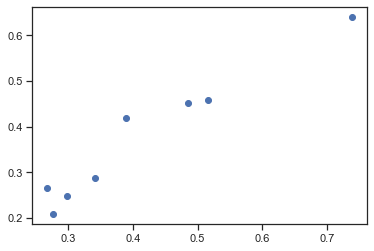

In [143]:
X = train_lm_scaled[cols].values
y = train_lm_scaled['consumption_per_km'].values

from sklearn import linear_model

linear_regr = linear_model.LinearRegression(n_jobs=-1)

linear_regr.fit(X, y)
y_pred_linear = linear_regr.predict(test_scaled[cols].values)
model_evaluation(y_test, y_pred_linear)
dump(linear_regr, open('MachineLearningModels/linear_regr_sklearn.pkl', 'wb'))

# Ann

RMSE = 0.03700099018388606
RMSPE = 6.780117999239938
RME = 5.958473119749152
R2 = 0.9391023110230107
max error= 0.09109996033793621


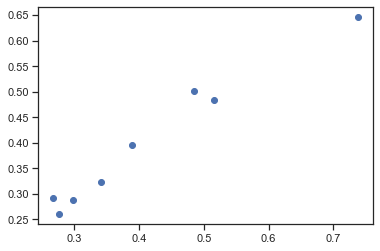

In [144]:
X = train_lm_scaled[cols].values
y = train_lm_scaled['consumption_per_km'].values

from sklearn.neural_network import MLPRegressor

ann_regr = MLPRegressor( activation='relu', alpha=0, hidden_layer_sizes= (50), max_iter=705000,
                        learning_rate='adaptive', warm_start=True, tol=1e-4, solver='lbfgs').fit(X, y)

#regr = MLPRegressor(random_state=1, max_iter=500, solver='lbfgs', activation='relu', alpha=0.002, hidden_layer_sizes=(150,)).fit(X, y)
y_ann=ann_regr.predict(test_scaled[cols].values)
ann_regr.score(test_scaled[cols].values, y_test)

model_evaluation(y_test, y_ann)
dump(ann_regr, open('MachineLearningModels/ann_regr.pkl', 'wb'))

In [137]:
print("Initialize Grid Search")
param_grid = { 
    'solver':['lbfgs'],
     #arning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [(150,100), (150,)],
    'activation': ["logistic"],
    'max_iter':[10500],
    }


# create and fit a regression model, testing each parameter value


model = MLPRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

Initialize Grid Search
GridSearchCV(estimator=MLPRegressor(),
             param_grid={'activation': ['logistic'],
                         'hidden_layer_sizes': [(150, 100), (150,)],
                         'max_iter': [10500], 'solver': ['lbfgs']})
0.4046867943731205
{'activation': 'logistic', 'hidden_layer_sizes': (150,), 'max_iter': 10500, 'solver': 'lbfgs'}


# Learning curve

max train =  0.7632797103674955
max test =  0.7374481011196576
Fitting time =  0.15452144479751587


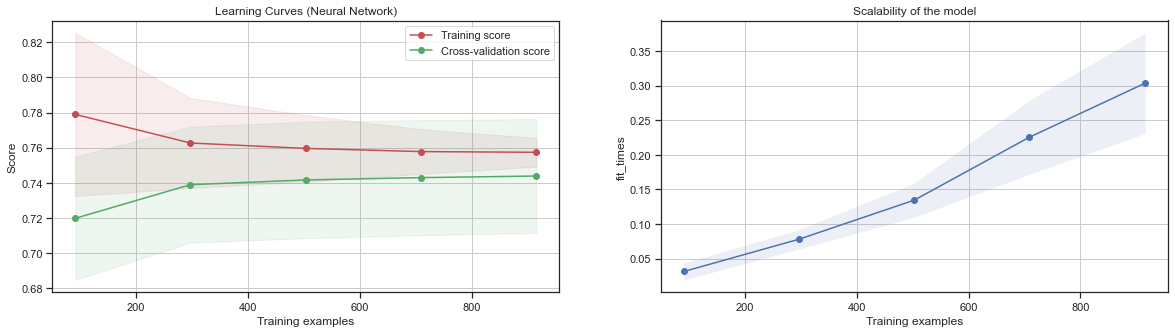

max train =  0.766423266607295
max test =  0.7102264349408406
Fitting time =  0.13397796583175658


<Figure size 432x288 with 0 Axes>

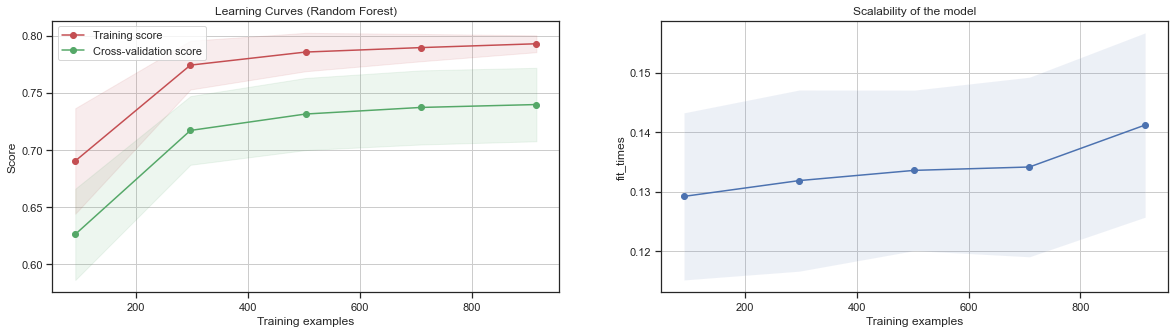

max train =  0.7631944991560544
max test =  0.7382794383613027
Fitting time =  0.0007136626243591309


<Figure size 432x288 with 0 Axes>

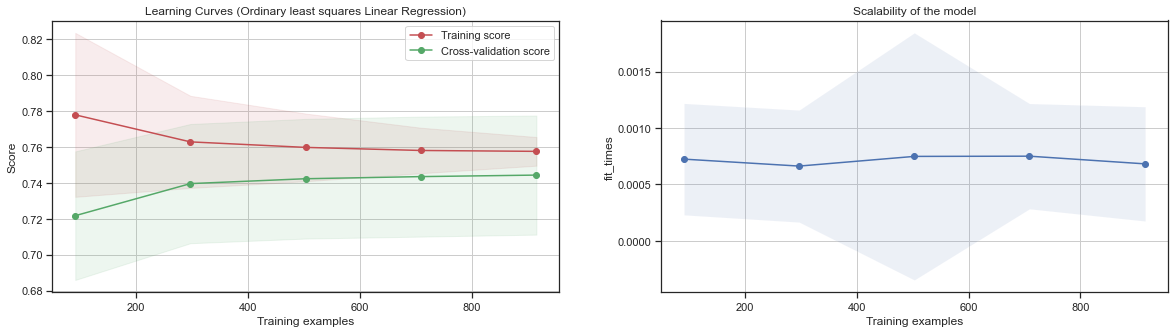

max train =  0.7950116657069843
max test =  0.7177116877724313
Fitting time =  0.07354231166839599


<Figure size 432x288 with 0 Axes>

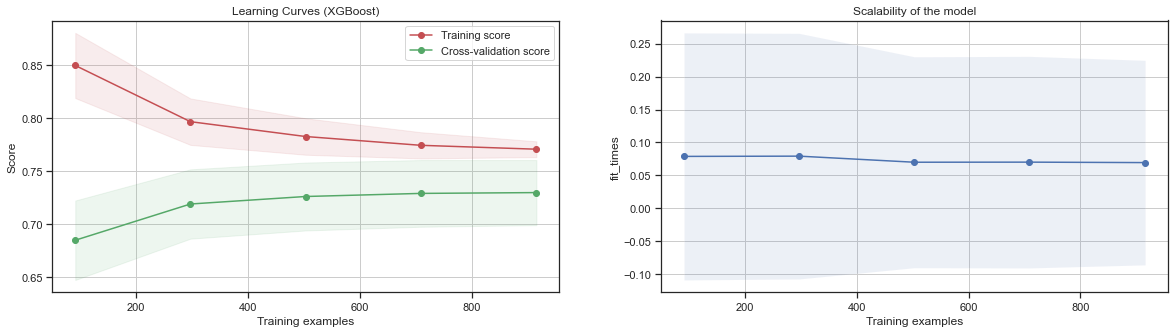

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
 
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    #if ylim is not None:
        #axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    print('max train = ', np.mean(train_scores))
    print('max test = ', np.mean(test_scores))
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    print('Fitting time = ', np.mean(fit_times))

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    '''
    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, np.sort(test_scores_mean), 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    '''
    return plt


title = "Learning Curves (Neural Network)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = MLPRegressor(random_state=1, activation='tanh', alpha=0,
                         hidden_layer_sizes= (110 ), max_iter=70500, solver='lbfgs', learning_rate='invscaling')
plot_learning_curve(estimator, title, X, y, # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)
plt.show()

plt.figure()
title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestRegressor(n_estimators = 53, max_features='auto', max_samples = 0.1,
                                  max_depth=8, criterion = 'mse', random_state = 0, n_jobs=-1)
plot_learning_curve(estimator, title, X, y, # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show() 

plt.figure()
title = "Learning Curves (Ordinary least squares Linear Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = linear_model.LinearRegression(n_jobs=-1)
plot_learning_curve(estimator, title, X, y,  # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()


plt.figure()
title = "Learning Curves (XGBoost)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 0.15,
                             max_depth = 2, n_estimators = 18)

plot_learning_curve(estimator, title, X, y, # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()